# Training and Testing

This notebook is for building the regional models with the broadcasting layers. For Google Colab only.

![picture](https://facultyprofiles.hkust.edu.hk/profiles/images/P000002589.jpg)

## Set up the environment

### Import the packages

In [ ]:
! pip install geopy
! pip install pykrige
import torch
import torch.nn as nn
import torch.nn.functional as F

import os, sys
import numpy as np

### Training device

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device {device}...')

Using device cuda...


### Saving and loading files to/from different places

- **Temporary files** will be saved in the COLAB workspace directory
- **Models** and other files necessary for long-term use will be saved in the drive directory 

In [ ]:
workspace_dir = '/content'
drive_dir = '/content/drive/Othercomputers/DESKTOP-P14JC7J/2130/code'
sys.path.append(drive_dir)

from data_utils.utils import *

### Copy the processed data here

The processed data should be saved on the Google drive.

In [ ]:
! mkdir data
! mkdir baseline-results
! cp ./drive/MyDrive/urop-paper2-data/* ./data
! cp ./drive/MyDrive/urop-paper2-baseline-results/* ./baseline-results

mkdir: cannot create directory ‘data’: File exists


## Dataset
The dataset used for training and testing.

In [ ]:
from data_utils.utils import *
from data_utils.obs import ObsReader

from torch.utils.data import Dataset

from datetime import datetime, date, time, timedelta

class RegionalDataset(Dataset):
  def __init__(self, train, device, test_target_stations = None):
    super().__init__()
    self.period = 'train' if train else 'test'
    self.device = device
    self.first_date = eval(f'{self.period}_first_dt').date()
    self.last_date = eval(f'{self.period}_last_dt').date()

    self.obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
    self.wrf_normalizing = np.load(f'{data_dir}/wrf_normalizing.npz')
    self.wrf_normalizing = (self.wrf_normalizing['mean'], self.wrf_normalizing['std'])
    self.cmaq_normalizing = np.load(f'{data_dir}/cmaq_normalizing.npz')
    self.cmaq_normalizing = (self.cmaq_normalizing['mean'], self.cmaq_normalizing['std'])

    target_wrf_match = load_dict(f'{data_dir}/{self.period}_target_wrf_match.pkl')
    target_cmaq_match = load_dict(f'{data_dir}/{self.period}_target_cmaq_match.pkl')

    source_obs_data = load_dict(f'{data_dir}/{self.period}_source_data.pkl')
    target_obs_data = load_dict(f'{data_dir}/{self.period}_target_data.pkl')

    assert list(target_obs_data.keys()) == list(target_wrf_match.keys()) == list(target_cmaq_match.keys())

    self.source_obs_reader = ObsReader(source_obs_data)
    self.target_obs_reader = ObsReader(target_obs_data, test_target_stations if not train else None)

    target_wrf_data = np.load(f'{data_dir}/{self.period}_target_wrf_data.npy')
    target_cmaq_data = np.load(f'{data_dir}/{self.period}_target_cmaq_data.npy')
        
    if train or test_target_stations is None:
      self.target_wrf_data, self.target_cmaq_data = target_wrf_data, target_cmaq_data
    else:
      test_target_station_indices = np.array([list(target_obs_data.keys()).index(st) for st in test_target_stations])
      self.target_wrf_data = target_wrf_data[:, test_target_station_indices]
      self.target_cmaq_data = target_cmaq_data[:, test_target_station_indices]

    assert len(self) == self.target_wrf_data.shape[0] == self.target_cmaq_data.shape[0]

    self.source_loc = load_dict(f'{data_dir}/source_loc.pkl')
    
    target_loc = load_dict(f'{data_dir}/{self.period}_target_loc.pkl')
    if train or test_target_stations is None:
      self.target_loc = target_loc
    else:
      self.target_loc = {st: target_loc[st] for st in test_target_stations}

  def get_source_obs(self, day0):
    first_dt = datetime.combine(day0-timedelta(days = history_days), time(0))
    last_dt = datetime.combine(day0-timedelta(days = 1), time(23))
    source_obs = self.source_obs_reader(first_dt, last_dt)
    out = {}
    for st, df in source_obs.items():
      means, stds = np.array([self.obs_normalizing[sp][0] for sp in df.columns]), np.array([self.obs_normalizing[sp][1] for sp in df.columns])
      out[st] = torch.nan_to_num(torch.tensor(((df.values - means) / stds).T, dtype = torch.float, device = self.device))
    return out

  def get_target_obs(self, day0):
    means, stds = np.array([self.obs_normalizing[sp][0] for sp in target_species]), np.array([self.obs_normalizing[sp][1] for sp in target_species])
    first_dt = datetime.combine(day0, time(0))
    last_dt = datetime.combine(day0 + timedelta(days = horizon_days - 1), time(23))
    target_obs = self.target_obs_reader(first_dt, last_dt)
    return torch.tensor(np.array([((df.values - means)/stds).T for df in target_obs.values()]), dtype = torch.float, device = self.device)

  def __getitem__(self, index):
    day0 = self.first_date + timedelta(days = history_days + index)

    source_obs = self.get_source_obs(day0)
    target_wrf = torch.tensor((self.target_wrf_data[index] - self.wrf_normalizing[0][:, None])/self.wrf_normalizing[1][:, None], dtype = torch.float, device = self.device)
    target_cmaq = torch.tensor((self.target_cmaq_data[index] - self.cmaq_normalizing[0][:, None])/self.cmaq_normalizing[1][:, None], dtype = torch.float, device = self.device)
    target_wrf_cmaq = torch.cat([target_wrf, target_cmaq], dim = -2)

    target_obs = self.get_target_obs(day0)

    return source_obs, target_wrf_cmaq, target_obs

  def __len__(self):
    return (self.last_date - self.first_date).days - (history_days + horizon_days) + 2

  def get_dist(self):
    return torch.tensor(batch_dist(np.array(list(self.target_loc.values())), np.array(list(self.source_loc.values()))), dtype = torch.float, device = self.device)


def regional_dataset_collate_fn(batch):
  source_obs_out, target_wrf_cmaq_out, target_obs_out = [], [], []
  for source_obs, target_wrf_cmaq, target_obs in batch:
    source_obs_out.append(source_obs)
    target_wrf_cmaq_out.append(target_wrf_cmaq)
    target_obs_out.append(target_obs)
  return torch.utils.data._utils.collate.default_collate(source_obs_out), torch.stack(target_wrf_cmaq_out, axis = 1), torch.stack(target_obs_out, axis = 1)

## Training
### Hyperparameters
Hyperparameters for training the model and model configurations.

In [ ]:
num_epoch = 32
batch_size = 128
learning_rate, gamma, step_size = 1e-3, 0.9, 100
broadcasting = 'Broadcasting'

### Initialization
Build the models, optimizers and learning rate schedulers, and the dataset

In [ ]:
# the model, the optimizer and the scheduler
from model import Regional
regional_model = Regional({st: len(df.columns) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}, broadcasting = broadcasting).to(device)
optimizer = torch.optim.Adam(regional_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma = gamma, step_size = step_size)

In [ ]:
from torch.utils.data import DataLoader

# the training set and the distance used
training_set = RegionalDataset(train = True, device = device)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, collate_fn=regional_dataset_collate_fn)
training_dist = training_set.get_dist()

# the validation set and the distance used
validation_set = RegionalDataset(train = False, device = device)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, collate_fn=regional_dataset_collate_fn)
validation_dist = validation_set.get_dist() 

### Training loop

In [ ]:
for i in range(num_epoch):
  regional_model.train()
  train_epoch_loss = 0.0
  for source_obs, target_wrf_cmaq, target_obs in training_loader:
    optimizer.zero_grad()
    out = regional_model(source_obs, target_wrf_cmaq, training_dist)
    mask = ~torch.isnan(target_obs)
    loss = torch.abs(out[mask] - target_obs[mask]).mean()
    with torch.no_grad():
      train_epoch_loss += loss.item() * target_obs.shape[1] / len(training_set)
    loss.backward()
    optimizer.step()
    scheduler.step()
  

  if hasattr(regional_model.broadcasting, 'distance_decay'):
    with torch.no_grad():
      regional_model.broadcasting.distance_decay.data.clamp_(0.0)

  valid_epoch_loss = 0.0
  regional_model.eval()
  with torch.no_grad():
    for source_obs, target_wrf_cmaq, target_obs in validation_loader:
      out = regional_model(source_obs, target_wrf_cmaq, validation_dist)
      mask = ~torch.isnan(target_obs)
      loss = torch.abs(out[mask] - target_obs[mask]).mean()
      valid_epoch_loss += loss.item() * target_obs.shape[1] / len(validation_set)

  print(f'Epoch {i}, training loss {train_epoch_loss:.3g}, validation loss {valid_epoch_loss:.3g}...')
  if train_epoch_loss < valid_epoch_loss:
    break

### Save the trained model

In [ ]:
import json
model_dir = f'{drive_dir}/models/{broadcasting}_model'
os.makedirs(model_dir, exist_ok = True)
torch.save(regional_model.state_dict(), f'{model_dir}/state_dict')
torch.save(optimizer.state_dict(), f'{model_dir}/optimizer_state_dict')
torch.save(scheduler.state_dict(), f'{model_dir}/scheduler_state_dict')
with open (f'{model_dir}/training_config.json', 'w') as f:
  json.dump({
    'num_epoch': num_epoch, 
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'step_size': step_size
  }, f)

## Testing
Test on the testing target stations that are neither training target stations nor source stations, report the results on multiple metrics.


### Load the trained model


In [ ]:
from model import Regional
broadcasting = 'Broadcasting'
model_dir = f'{drive_dir}/models/{broadcasting}_model'
regional_model = Regional({st: len(df.columns) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}, broadcasting = broadcasting).to(device)
regional_model.load_state_dict(torch.load(f'{model_dir}/state_dict'))

<All keys matched successfully>

### Load the testing data

In [ ]:
# Only the testing target stations that are neither training target stations nor source stations
source_stations = set(load_dict(f'{data_dir}/source_loc.pkl').keys())
train_target_stations = set(load_dict(f'{data_dir}/train_target_loc.pkl').keys())
test_target_stations = set(load_dict(f'{data_dir}/test_target_loc.pkl').keys())

test_target_stations = list(test_target_stations - train_target_stations - source_stations)

In [ ]:
# denormalize the output
obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
means, stds = np.array([obs_normalizing[sp][0] for sp in target_species]), np.array([obs_normalizing[sp][1] for sp in target_species])

In [ ]:
# the testing set
testing_set = RegionalDataset(train = False, device = device, test_target_stations = test_target_stations)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, collate_fn=regional_dataset_collate_fn)
test_dist = testing_set.get_dist()

In [ ]:
regional_model.eval()
assert not regional_model.training

In [ ]:
pred, y = [], []
with torch.no_grad():
  testing_loss = 0.0
  for source_obs, target_wrf_cmaq, target_obs in testing_loader:
    pred.append(regional_model.predict(source_obs, target_wrf_cmaq, test_dist, (means, stds)))
    y.append(target_obs.cpu().numpy() * stds[:, None] + means[:, None])
pred, y = np.concatenate(pred, axis = 1), np.concatenate(y, axis = 1)
pred_by_day, y_by_day = pred.reshape(*pred.shape[:-1], 2, 24), y.reshape(*y.shape[:-1], 2, 24)

### Load the baseline data
- CMAQ prediction
- Spatial correction via multiple different interpolation methods

In [ ]:
# CMAQ
cmaq_pred = load_dict(f'baseline-results/cmaq_pred.pkl')
cmaq_pred = np.stack([cmaq_pred[st] for st in test_target_stations])
cmaq_pred_by_day = cmaq_pred.reshape(*cmaq_pred.shape[:-1], 2, 24)

### The evaluation metrics:
- `MBE` is used to evaluate the bias issue.
- Others will be presented in the publication.

In [ ]:
def MBE(pred, y, axis = 0):
  return np.nanmean(pred - y, axis = axis) / (np.nanmean(y, axis = axis))

def MAE(pred, y, axis = 0):
  return np.nanmean(np.abs(pred - y), axis = axis)

def RMSE(pred, y, axis = 0):
  return np.sqrt(np.nanmean((pred - y)**2, axis = axis))

def SMAPE(pred, y, axis = 0):
  return 200 * np.nanmean(np.abs(pred - y) / (np.abs(pred) + np.abs(y)), axis = axis)

def R(pred, y, axis = 0):
  mask = ~np.isnan(y)
  n = mask.sum(axis = axis, keepdims = True)
  pred_mean = np.sum(pred * mask, axis = axis, keepdims = True) / n
  y_mean = np.nanmean(y, axis = axis, keepdims = True)
  r = np.nansum((pred - pred_mean) * (y - y_mean), axis = axis)/ np.sqrt(np.sum(mask * (pred - pred_mean)**2, axis = axis) * np.nansum((y - y_mean)**2, axis = axis))
  return r

In [ ]:
metrics = [MAE, RMSE, SMAPE, R]

### Print the evaluation results

In [ ]:
import pandas as pd
results = {(sp, j): pd.DataFrame(columns = [MBE.__name__]+[m.__name__ for m in metrics], index = ['CMAQ', broadcasting]) for sp in target_species for j in range(horizon_days)}

for m in [MBE]+metrics:
  cmaq_arr = m(cmaq_pred_by_day, y_by_day, (0, 1, 4))
  broadcasting_arr = m(pred_by_day, y_by_day, (0, 1, 4))
  
  for i, sp in enumerate(target_species):
    for j in range(horizon_days):
      results[sp, j].loc['CMAQ', m.__name__] = cmaq_arr[i, j]
      results[sp, j].loc[broadcasting, m.__name__] = broadcasting_arr[i, j] 

In [ ]:
results['FSPMC', 0]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.367759,12.62485,21.855939,59.138722,0.555296
Broadcasting,0.01616,6.455028,9.156938,41.245278,0.738561


In [ ]:
results['FSPMC', 1]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.395993,13.008929,22.383502,59.826695,0.548784
Broadcasting,0.097149,7.236571,9.758254,45.065854,0.704721


In [ ]:
results['O3', 0]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.334648,16.098667,21.062601,60.049082,0.613268
Broadcasting,-0.018247,10.649964,14.472741,46.003456,0.741111


In [ ]:
results['O3', 1]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.330544,16.328002,21.220851,61.078863,0.600618
Broadcasting,0.017269,11.18542,15.216114,47.528244,0.71054


### Plot the performance for each time step

In [ ]:
import matplotlib.pyplot as plt
metric_values_by_hour = {}
cmaq_metric_values_by_hour = {}
for m in metrics:
  cmaq_arr = m(cmaq_pred, y, (1, 2))
  broadcasting_arr = m(pred, y, (1, 2))
  for i, sp in enumerate(target_species):
    cmaq_metric_values_by_hour[sp, m.__name__] = cmaq_arr[i]
    metric_values_by_hour[sp, m.__name__] = broadcasting_arr[i]

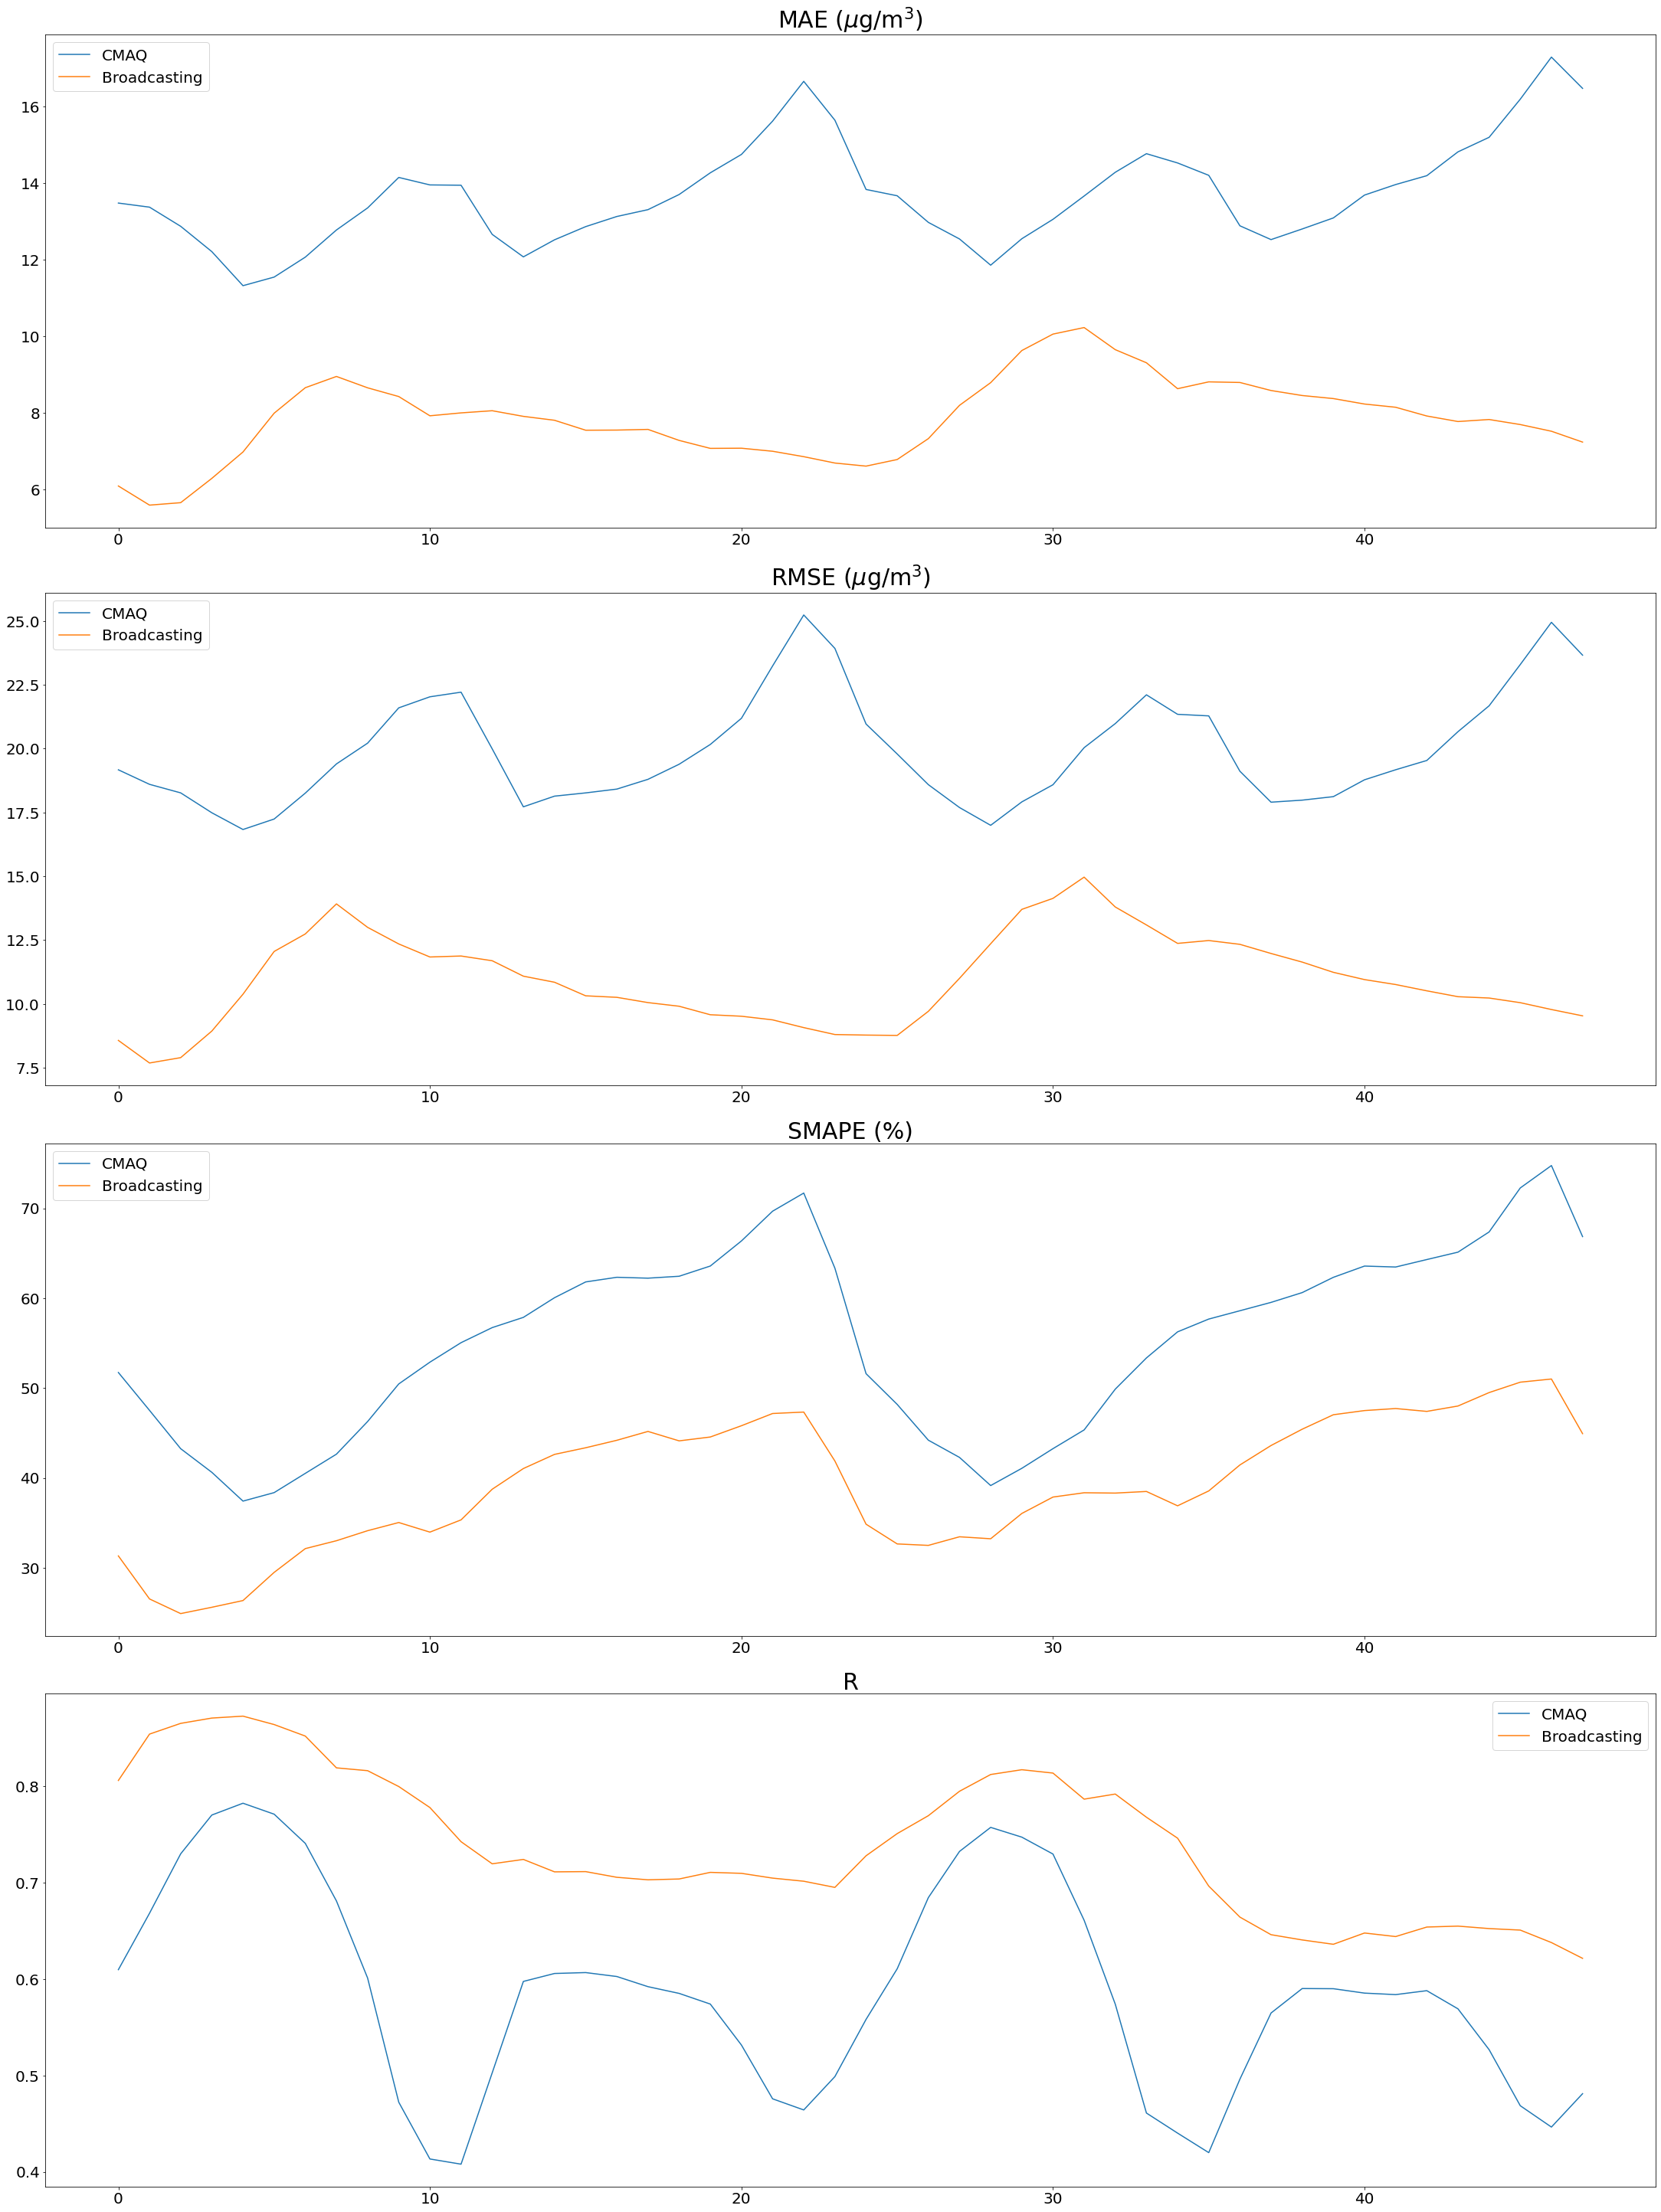

In [ ]:
fspmc_fig, axes = plt.subplots(4, 1, figsize = (30, len(metrics) * 10), constrained_layout = True)
units = ['$\mu$g/m$^3$', '$\mu$g/m$^3$', '%', None]
for ax, m, u in zip(axes, metrics, units):
  ax.set_title(f'{m.__name__}' + (f' ({u})' if u is not None else ''), fontsize = 30)
  ax.xaxis.set_tick_params(labelsize = 20)
  ax.yaxis.set_tick_params(labelsize = 20)
  ax.plot(cmaq_metric_values_by_hour['FSPMC', m.__name__], label = 'CMAQ')
  ax.plot(metric_values_by_hour['FSPMC', m.__name__], label = 'Broadcasting')
  ax.legend(fontsize = 20)

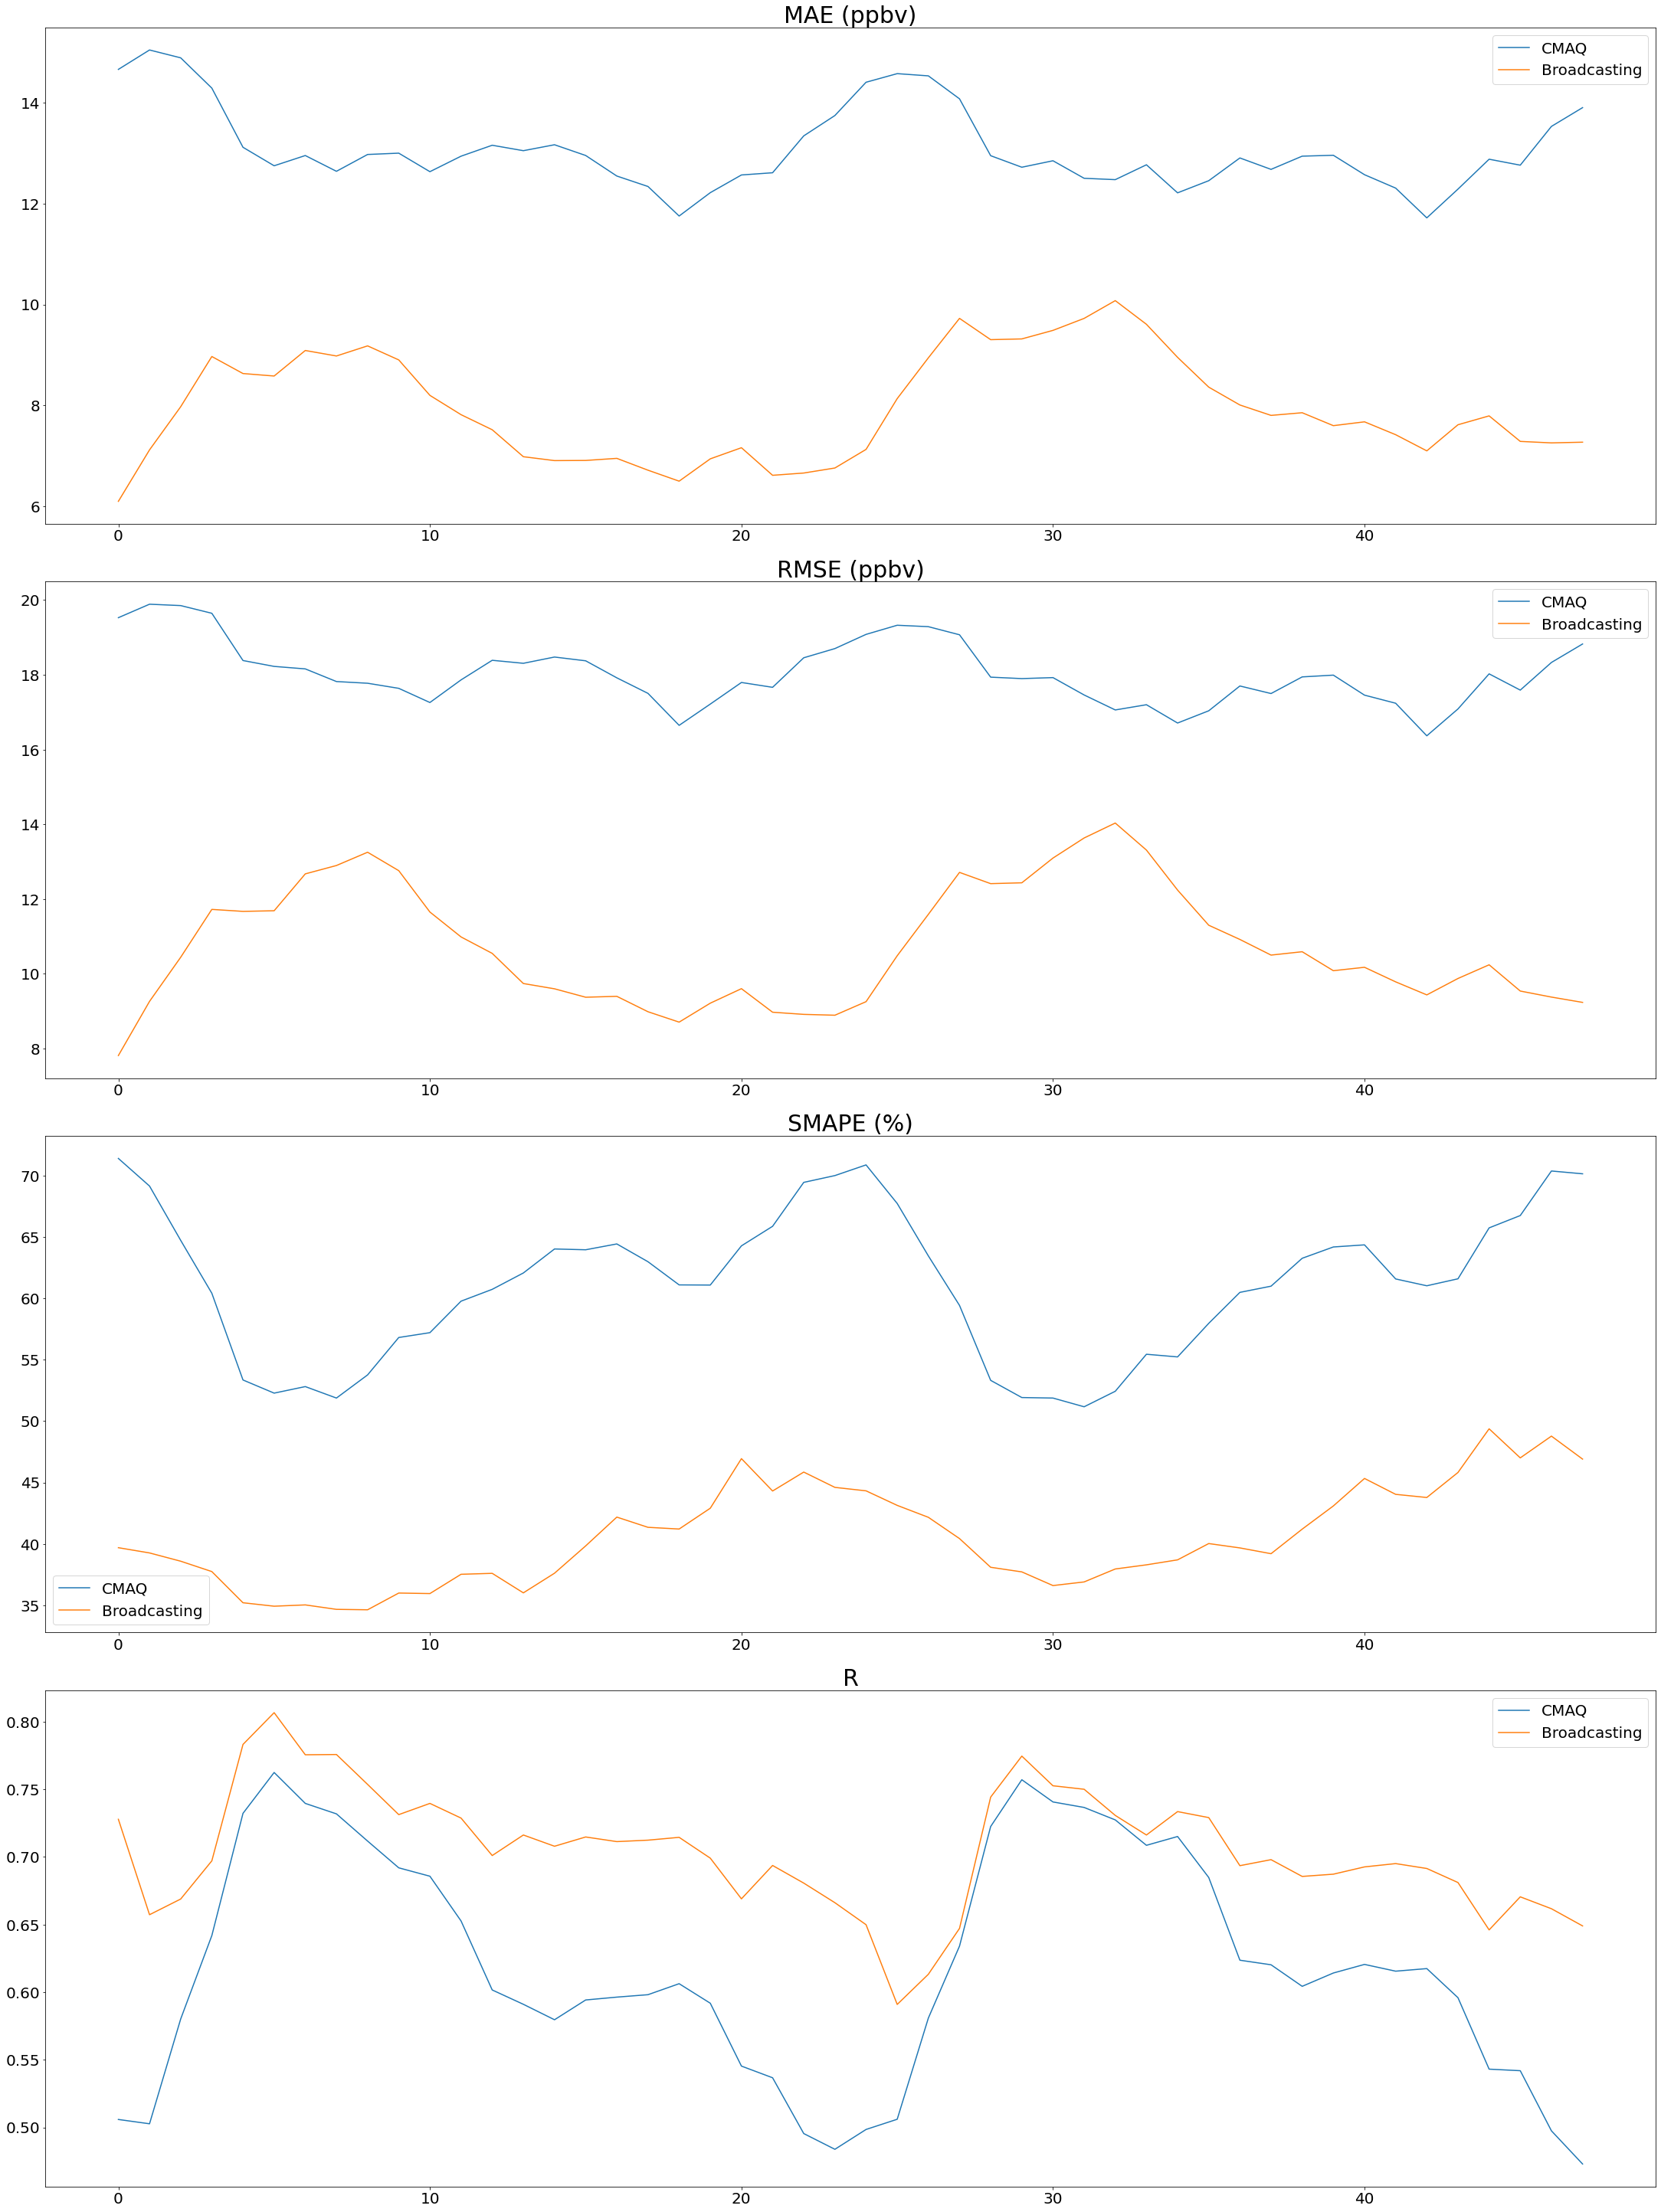

In [ ]:
o3_fig, axes = plt.subplots(4, 1, figsize = (30, len(metrics) * 10), constrained_layout = True)
units = ['ppbv', 'ppbv', '%', None]
for ax, m, u in zip(axes, metrics, units):
  ax.set_title(f'{m.__name__}' + (f' ({u})' if u is not None else ''), fontsize = 30)
  ax.xaxis.set_tick_params(labelsize = 20)
  ax.yaxis.set_tick_params(labelsize = 20)
  ax.plot(cmaq_metric_values_by_hour['O3', m.__name__], label = 'CMAQ')
  ax.plot(metric_values_by_hour['O3', m.__name__], label = 'Broadcasting')
  ax.legend(fontsize = 20)

### Plot the time series by day for each test stations

In [ ]:
test_target_loc = load_dict(f'{data_dir}/test_target_loc.pkl')
os.makedirs(f'{drive_dir}/plots/by_station', exist_ok = True)
for st, y_arr, cmaq_pred_arr, pred_arr in zip(test_target_stations, y_by_day, cmaq_pred_by_day, pred_by_day):
  fig, axes = plt.subplots(2, 2, figsize = (50, 30), constrained_layout = True)
  lat, lon = test_target_loc[st]
  fig.suptitle(f'{st} ({lat:.2f}°N, {lon:.2f}°E)', fontsize = 40)
  for i, (sp, u) in enumerate(zip(target_species, ['$\mu$g/m$^3$', 'ppbv'])):
    for j in range(horizon_days):
      time_axis = [test_first_dt.date() + timedelta(days = k + history_days + j) for k in range(y.shape[1])]
      axes[i, j].set_title(f'{sp} ({u}), day {j}', fontsize = 30)
      axes[i, j].plot(time_axis, y_arr[:, i, j].mean(axis = -1), 'ro', label = 'Observation', markersize = 5)
      axes[i, j].plot(time_axis, cmaq_pred_arr[:, i, j].mean(axis = -1), 'g', label = 'CMAQ')
      axes[i, j].plot(time_axis, pred_arr[:, i, j].mean(axis = -1), 'b', label = 'Broadcasting')
      axes[i, j].legend(fontsize = 25)
      axes[i, j].xaxis.set_tick_params(labelsize = 20)
      axes[i, j].yaxis.set_tick_params(labelsize = 20)
  fig.savefig(f'{drive_dir}/plots/by_station/{st}.png')
  plt.close(fig)